In [460]:
import json

from solc import compile_standard
from eth_tester import PyEVMBackend, EthereumTester
import web3
web3.eth.handleRevert = True

from matplotlib import pyplot as plt
import seaborn as sns

In [436]:
def _median(arr):
    arr_copy = arr[:]
    arr_copy.sort()
    n = len(arr)
    if n % 2 == 1:
        return arr_copy[n // 2]
    else:
        return (arr_copy[n // 2 - 1] + arr_copy[n // 2]) / 2 

In [461]:
def get_contract(filename, contract_name):

    with open(filename) as f:
        compiled_sol = compile_standard({
            "language": "Solidity",
            "sources": {
                filename: {
                    "content": f.read()
                }
            },
            "settings": {
                "outputSelection": {
                    "*": {
                        "*": [
                            "metadata", "evm.bytecode",
                            "evm.bytecode.sourceMap"
                        ]
                    }
                }
            }
        })
    
    # get bytecode
    bytecode = compiled_sol['contracts'][filename][contract_name]['evm']['bytecode']['object']
    # get abi
    abi = json.loads(compiled_sol['contracts'][filename][contract_name]['metadata'])['output']['abi']

    contract = w3.eth.contract(abi=abi, bytecode=bytecode)

    # Submit the transaction that deploys the contract
    tx_hash = contract.constructor().transact()
    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.getTransactionReceipt(tx_hash)

    return w3.eth.contract(
        address=tx_receipt.contractAddress,
        abi=abi
    )

In [462]:
# web3.py instance
w3 = web3.Web3(Web3.EthereumTesterProvider(EthereumTester(PyEVMBackend())))
# set pre-funded account as sender
w3.eth.default_account = w3.eth.accounts[0]

In [463]:
my_median = get_contract('Median.sol', 'Median')
cl_median = get_contract('ChainlinkMedian.sol', 'Median')

# TEST gas estimate

In [468]:
import itertools
import random
import pandas as pd

df = pd.DataFrame({
    'length': pd.Series([], dtype='int'), 
    'gas_cost': pd.Series([], dtype='int'), 
    'type': pd.Series([], dtype='str'), 
    'nrun': pd.Series([], dtype='int'), 
})

def _insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

def factorial(n):
    res = 1
    for x in range(1, n + 1):
        res *= x
    return res

NPERMS = 100

for n in range(1, 31):
    arr = list(range(10, 10 * n + 1, 10))
    for r in range(NPERMS):
        assert len(arr) == n
        random.shuffle(arr)
        
        ### chainlink (baseline)
        gas_cost = cl_median.functions.calculate(arr[:]).estimateGas()
        row = [n, gas_cost, 'chainlink', r]
        _insert(df, row)
        
        ### all quickselect, no direct computation
        fn = my_median.functions.compute(arr[:], 0)
        gas_cost = fn.estimateGas()
        res = fn.call()
        assert res == _median(arr) # extra check, just in case
        row = [n, gas_cost, 'my-median_only-quickselect', r]
        _insert(df, row)
        
        ### direct computation for <= 16
        fn = my_median.functions.compute(arr[:], 16)
        gas_cost = fn.estimateGas()
        res = fn.call()
        assert res == _median(arr) # extra check, just in case
        row = [n, gas_cost, 'my-median_direct-comparison', r]
        _insert(df, row)
        
    print(n)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


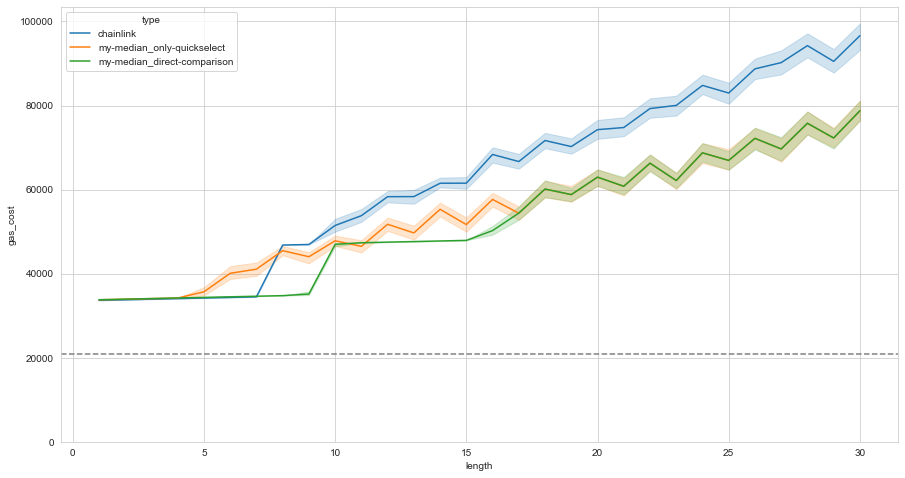

In [469]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))

g = sns.lineplot(data=df, x="length", y="gas_cost", hue="type", ci=99);

# mark minimum gas for any txn
plt.axhline(21_000, ls='--', color='grey')

#plt.xlim(0, 8);
plt.ylim(0,);